PREDICTING WITH CONVOLUTIONAL NEURAL NETWORKS (WARTINI'S PAPER ARCHITECTURE)

---




### 1. Google Colab runtime setup [Optional]

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Clone and install spectrai package 
!git clone https://github.com/franckalbinet/spectrai.git 
!pip install /content/spectrai 

Cloning into 'spectrai'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 216 (delta 47), reused 84 (delta 25), pack-reused 99
Receiving objects: 100% (216/216), 76.51 MiB | 21.44 MiB/s, done.
Resolving deltas: 100% (53/53), done.
Checking out files: 100% (97/97), done.
Processing ./spectrai
     |████████████████████████████████| 20.0MB 1.5MB/s 
     |████████████████████████████████| 10.1MB 21.8MB/s 
     |████████████████████████████████| 6.7MB 41.8MB/s 
     |████████████████████████████████| 25.2MB 128kB/s 
     |████████████████████████████████| 225kB 37.6MB/s 
     |████████████████████████████████| 86.3MB 44kB/s 
     |████████████████████████████████| 112kB 43.5MB/s 
     |████████████████████████████████| 675kB 36.2MB/s 
     |████████████████████████████████| 102kB 12.4MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 450kB

In [3]:
# Prepare /root folder content
!cp -r /content/drive/My\ Drive/Colab\ Notebooks/data/data_spectrai /root

In [8]:
# Create configuration file
!mkdir /root/.spectrai_config & cp /content/spectrai/config.toml /root/.spectrai_config

### 2. Import packages

In [24]:
# To train on a GPU
!pip install tensorflow-gpu

In [29]:
from spectrai.datasets.kssl import (get_tax_orders_lookup_tbl, load_data)
from spectrai.vis.spectra import (plot_spectra)
from spectrai.metrics.keras import rpd, r2_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error 

import numpy as np

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras import layers, models, Model
import tensorflow.keras.backend as K
import tensorflow.keras.utils as utils

import matplotlib.pyplot as plt

### 3. Load KSSL dataset

In [10]:
# Loading data ("Potassium, NH4OAc: 725" or "CEC": 723, "Clay": 334 for instance)
X, X_names, y, y_names, instances_id = load_data(analytes=[334])

In [11]:
print('X shape: ', X.shape)
print('X approx. memory size: {} MB'.format(X.nbytes // 10**6))
print('y approx. memory size: {} MB'.format(y.nbytes // 10**6))
print('Wavenumbers: ', X_names)
print('Target variable: ', y_names)

X shape:  (47014, 1764)
X approx. memory size: 331 MB
y approx. memory size: 1 MB
Wavenumbers:  [3999 3997 3995 ...  603  601  599]
Target variable:  ['lay_depth_to_top' 'order_id' 'calc_value']


(array([11243., 21442., 31819., 39356., 43355., 45327., 46383., 46839.,
        46986., 47014.]),
 array([-0.6077344 ,  9.06746014, 18.74265468, 28.41784922, 38.09304376,
        47.7682383 , 57.44343284, 67.11862738, 76.79382192, 86.46901646,
        96.144211  ]),
 <a list of 10 Patch objects>)

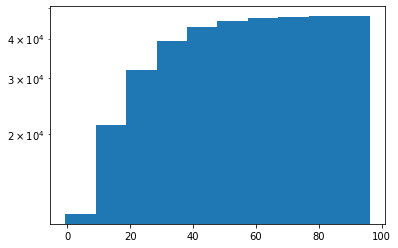

In [12]:
plt.hist(y[:,-1], cumulative=True, log=True)

### 4. Data preparation

In [13]:
# Keeping data with analyte concentration > 0 only and for 'alfisols' taxonomic order only.
#TAX_ORDER_ID = 0

idx_y_valid = y[:, -1] > 0
#idx_y_valid = (y[:, -1] > 0) & (y[:, -1] <= np.quantile(y[:, -1], 0.5))
#idx_order = y[:,1] == TAX_ORDER_ID
#idx = idx_y_valid & idx_order

X = X[idx_y_valid,:]
y = y[idx_y_valid,:]

# Scale data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [14]:
# Creating train, valid, test sets
#X, X_test, y, y_test = train_test_split(X, y[:, -1], test_size=0.20, random_state=42)
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y[:, -1], test_size=0.2, random_state=42)

print('X test shape: ', X_test.shape)
print('y test shape: ', y_test.shape)
print('X valid shape: ', X_valid.shape)
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)

X test shape:  (9342, 1764)
y test shape:  (9342, 3)
X valid shape:  (7473, 1764)
X train shape:  (29891, 1764)
y train shape:  (29891,)


### 5. Defining CNN model

In [30]:
# Wartini's architecture
activation = 'relu'
input_dim = X_train.shape[1]

model = keras.models.Sequential()
model.add(layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

model.add(layers.Conv1D(32, 20, activation=activation))
model.add(layers.MaxPool1D(2))

model.add(layers.Conv1D(64, 20, activation=activation))
model.add(layers.MaxPool1D(5))

model.add(layers.Conv1D(128, 20, activation=activation))
model.add(layers.MaxPool1D(5))

model.add(layers.Conv1D(256, 20, activation=activation))
model.add(layers.MaxPool1D(5))

model.add(layers.Dropout(rate=0.4))

model.add(layers.Flatten())

model.add(layers.Dense(100, activation=activation))

model.add(layers.Dropout(rate=0.2))

model.add(layers.Dense(1,  activation='linear'))

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse', metrics=[r2_score])
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1764, 1)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1745, 32)          672       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 872, 32)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 853, 64)           41024     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 170, 64)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 151, 128)          163968    
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 30, 128)          

### 6. Training the model

In [31]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-3)

In [ ]:
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid), callbacks=[reduce_lr])

Epoch 1/200
935/935 [==============================] - 17s 19ms/step - loss: 190.3666 - r2_score: 0.2301 - val_loss: 120.9463 - val_r2_score: 0.4956
Epoch 2/200
935/935 [==============================] - 17s 18ms/step - loss: 106.7667 - r2_score: 0.5598 - val_loss: 82.7355 - val_r2_score: 0.6544
Epoch 3/200
935/935 [==============================] - 17s 18ms/step - loss: 82.6192 - r2_score: 0.6618 - val_loss: 64.0612 - val_r2_score: 0.7401
Epoch 4/200
935/935 [==============================] - 17s 18ms/step - loss: 73.2144 - r2_score: 0.7011 - val_loss: 54.5021 - val_r2_score: 0.7783
Epoch 5/200
935/935 [==============================] - 17s 18ms/step - loss: 66.2825 - r2_score: 0.7261 - val_loss: 53.3908 - val_r2_score: 0.7837
Epoch 6/200
935/935 [==============================] - 17s 18ms/step - loss: 62.4873 - r2_score: 0.7414 - val_loss: 48.8066 - val_r2_score: 0.8036
Epoch 7/200
935/935 [==============================] - 17s 18ms/step - loss: 57.4834 - r2_score: 0.7631 - val_loss:

### 7. Saving model

In [ ]:
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/models/cnn-wartini-200-epochs-K.h5'
model.save(MODEL_PATH)

In [ ]:
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks/models/cnn-basic-50-epochs-cec.h5'
model = models.load_model(MODEL_PATH, custom_objects={'rpd': rpd})

### 8. Assessing learning

In [ ]:
# Concat all runs history
def concat_history(*args):
  all_history = args[0].history.copy()
  for hist in args[1:]:
    for k in all_history.keys():
      all_history[k] += hist.history[k]
  return all_history

all_history = concat_history(history)

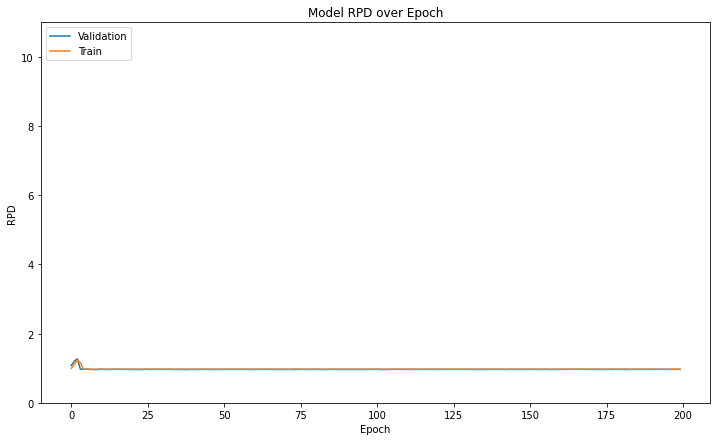

In [ ]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(figsize=(12,7))
_ = ax.plot(all_history['val_rpd'])
_ = ax.plot(all_history['rpd'])
plt.ylim(0, 11)
plt.title('Model RPD over Epoch')
plt.ylabel('RPD')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')

In [ ]:
_, _rpd = model.evaluate(X_test, y_test[:, -1])
print('RPD on test set:', _rpd)

304/304 [==============================] - 2s 6ms/step - loss: 1.3855 - rpd: 0.9691
RPD on test set: 0.9690957069396973


In [ ]:
print('R2 on test set: ', r2_score(model.predict(X_test), y_test[:, -1]))

R2 on test set:  0.0


### 9. Wavenumbers influence

Based on **"Convolutional neural network for simultaneous prediction of several soil properties using visible/near-infrared, mid-infrared, and their combined spectra"** paper: https://www.sciencedirect.com/science/article/abs/pii/S0016706119300588

In [ ]:
# 1. Draw 1000 samples from the test set
NB_SAMPLE = 1000
random_indices = np.random.choice(X_test.shape[0], size=NB_SAMPLE, replace=False)
X_test_sample = X_test[random_indices, :]
print(X_test_sample.shape)
 

(1000, 1764)


In [ ]:
# 2. Take the mean of all spectra
spectrum_mean = np.mean(X_test_sample, axis = 0).reshape(1, -1)
spectra_mean = np.repeat(spectrum_mean, repeats=NB_SAMPLE, axis=0)

In [ ]:
# 3. Perturbate spectra_mean with X_test_sample and take predictions variance
NB_WN = X_test_sample.shape[1]
predictions_variance = np.zeros(NB_WN)

for wn in range(NB_WN):
  spectra_var = np.copy(spectra_mean)
  spectra_var[:,wn] = X_test_sample[:,wn]
  predictions_variance[wn] = np.var(model.predict(spectra_var))

predictions_variance

array([0., 0., 0., ..., 0., 0., 0.])

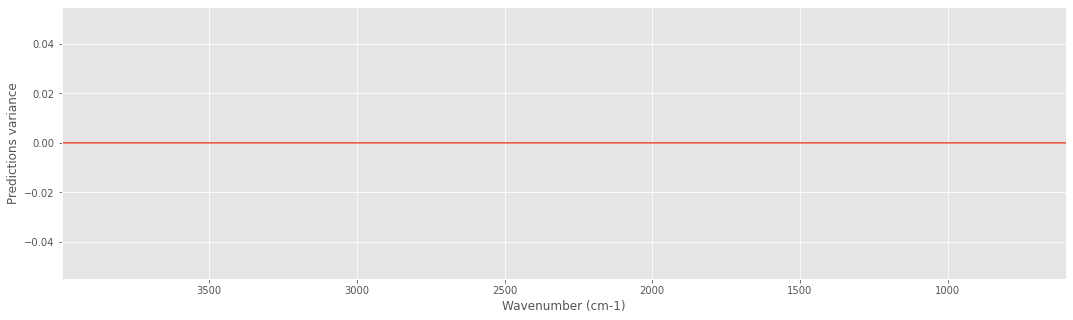

In [ ]:
def plot_variance(variance, X_names, figsize=(18, 5)):
  with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(np.max(X_names), np.min(X_names))
    plt.xlabel('Wavenumber (cm-1)')
    plt.ylabel('Predictions variance')
    _ = ax.plot(X_names, variance)

plot_variance(predictions_variance, X_names)


### 10. Error analysis 

In [ ]:
diff = np.abs(model.predict(X_test).ravel() - y_test)

In [ ]:
diff.shape

(9728,)

(array([9.594e+03, 1.020e+02, 1.300e+01, 1.200e+01, 4.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([1.19151554e-05, 1.53583196e+00, 3.07165201e+00, 4.60747206e+00,
        6.14329211e+00, 7.67911216e+00, 9.21493221e+00, 1.07507523e+01,
        1.22865723e+01, 1.38223924e+01, 1.53582124e+01]),
 <a list of 10 Patch objects>)

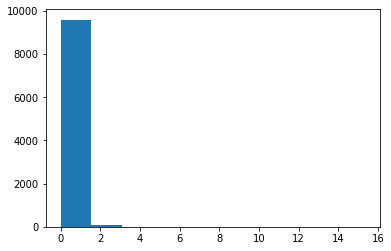

In [ ]:
plt.hist(diff, bins=10)